In [1]:
import pandas as pd

from scipy.stats import spearmanr

In [95]:
exemplars_llama31_70b = pd.read_csv("italian/formatted/temp_00/llama3.1-70b-it-textual-temp_00_alliters.csv")
exemplars_llama31 = pd.read_csv("italian/formatted/temp_00/llama3.1-it-textual-temp_00_alliters.csv")
exemplars_nemo = pd.read_csv("italian/formatted/temp_00/nemo-it-textual-temp_00_alliters.csv")

data_human = pd.read_excel("../data/best_human_exemplars.xlsx")

In [106]:
exemplars_nemo

,participant,category,category_it,concept,exemplar,clean_exemplar,rank
0,nemo-iter1,plants,piante,abete,abete rosso,rosso,1
1,nemo-iter1,plants,piante,abete,abete bianco,bianco,2
2,nemo-iter1,plants,piante,abete,abete argentato,argentato,3
3,nemo-iter1,plants,piante,abete,abete dei boschi,dei boschi,4
4,nemo-iter1,plants,piante,abete,abete di nordmann,di nordmann,5
...,...,...,...,...,...,...,...
3234,nemo-iter1,furnishings/fittings,arredamenti/accessori,vite,vite a testa a brugola a tri-wing,a testa a brugola a tri-wing,13
3235,nemo-iter1,furnishings/fittings,arredamenti/accessori,vite,vite a testa a brugola a spanner,a testa a brugola a spanner,14
3236,nemo-iter1,furnishings/fittings,arredamenti/accessori,vite,vite a testa a brugola a security torx,a testa a brugola a security torx,15
3237,nemo-iter1,furnishings/fittings,arredamenti/accessori,vite,vite a testa a brugola a security torx plus,a testa a brugola a security torx plus,16


In [75]:
def get_ranks(reference_order, lm_list):
    ranks = []
    for ref in reference_order:
        if ref not in lm_list:
            # ranks.append(0)
            continue
        else:
            ranks.append(lm_list.index(ref) + 1)
    return ranks

In [79]:
def compute_spearmanr(concept, data_lm, data_human):
    exemplars = data_lm[data_lm.concept == concept].clean_exemplar.to_list()
    reference = data_human[data_human.concept == concept.upper()].sort_values(by="availability", ascending=False).exemplar.to_list()
    reference = [elem.split("_")[-1] for elem in reference]

    f_reference = [elem for elem in reference if elem in exemplars]
    f_exemplars = [elem for elem in exemplars if elem in reference]

    ranks_lm = get_ranks(f_reference, f_exemplars)
    ranks_ref = [i + 1 for i in range(len(ranks_lm))]

    corr, pval = spearmanr(ranks_lm, ranks_ref)
    return corr, pval

In [112]:
exemplars_llama31_70b[exemplars_llama31_70b.concept == "abete"].category[0]

'plants'

In [114]:
df_dict = {
    "concept": [],
    "category": [],
    "llama3.1-70b": [],
    "llama3.1": [],
    "nemo": [],
}

for concept in exemplars_llama31_70b.concept.unique():
    category = exemplars_llama31_70b[exemplars_llama31_70b.concept == concept].category.tolist()[0]
    corr_llama70b, pval_llama70b = compute_spearmanr(concept, exemplars_llama31_70b, data_human)
    corr_llama, pval_llama = compute_spearmanr(concept, exemplars_llama31, data_human)
    corr_nemo, pval_nemo = compute_spearmanr(concept, exemplars_nemo, data_human)

    df_dict["concept"].append(concept)
    df_dict["category"].append(category)
    df_dict["llama3.1-70b"].append(corr_llama70b)
    df_dict["llama3.1"].append(corr_llama)
    df_dict["nemo"].append(corr_nemo)

df_corr = pd.DataFrame.from_dict(data=df_dict, orient="columns")
df_corr = df_corr.fillna(0)

In [115]:
df_corr

,concept,category,llama3.1-70b,llama3.1,nemo
0,abete,plants,-1.000000,1.0,1.0
1,aereo,vehicles,0.000000,0.0,1.0
2,agenda,stationery,0.800000,0.0,0.5
3,appendiabiti,furnishings/fittings,1.000000,0.0,0.0
4,armadio,furniture,0.900000,0.5,1.0
...,...,...,...,...,...
182,uovo,foods,0.600000,1.0,0.7
183,vaso,furnishings/fittings,-0.200000,0.0,-0.2
184,verdura,foods,0.607143,1.0,0.6
185,videogioco,hobbies,0.000000,0.0,1.0


<Axes: >

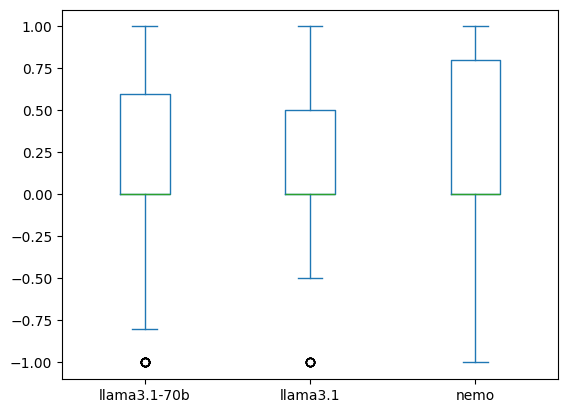

In [104]:
df_corr.plot.box()

In [99]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

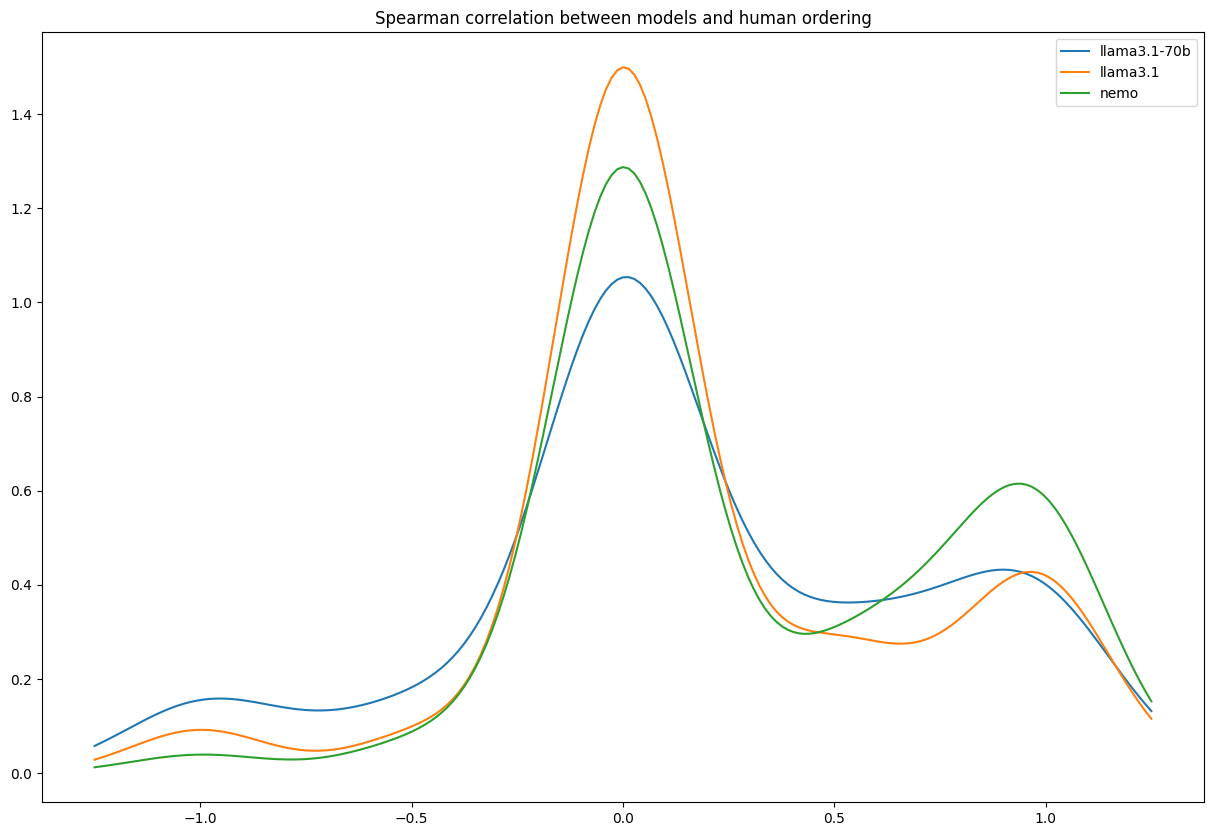

In [102]:
fig, ax = plt.subplots(figsize=(15, 10))
x = np.linspace(-1.25, 1.25, len(df_corr["nemo"]))

kde = gaussian_kde(df_corr["llama3.1-70b"])
ax.plot(x, kde(x), label="llama3.1-70b")

kde = gaussian_kde(df_corr["llama3.1"])
ax.plot(x, kde(x), label="llama3.1")

# kde = gaussian_kde(df_corr.mistral_2nd)
# ax.plot(x, kde(x), label="mistral (2nd)")

kde = gaussian_kde(df_corr["nemo"])
ax.plot(x, kde(x), label="nemo")
 
# kde = gaussian_kde(df_corr.llava_txt)
# ax.plot(x, kde(x), label="llava")
 
# kde = gaussian_kde(df_corr.llava_txt_2nd)
# ax.plot(x, kde(x), label="llava (2nd)")
#   
# kde = gaussian_kde(df_corr.nemo_2nd)
# ax.plot(x, kde(x), label="nemo (2nd)")

plt.title("Spearman correlation between models and human ordering")
plt.legend()
plt.show()

In [118]:
_selected = ["concept", "category", "llama3.1-70b", "llama3.1", "nemo"] #, "llava_vis"]
cat_dfs_tonemo = {k: v[_selected].sort_values("llama3.1-70b", ascending=False) for k, v in df_corr.groupby("category")}

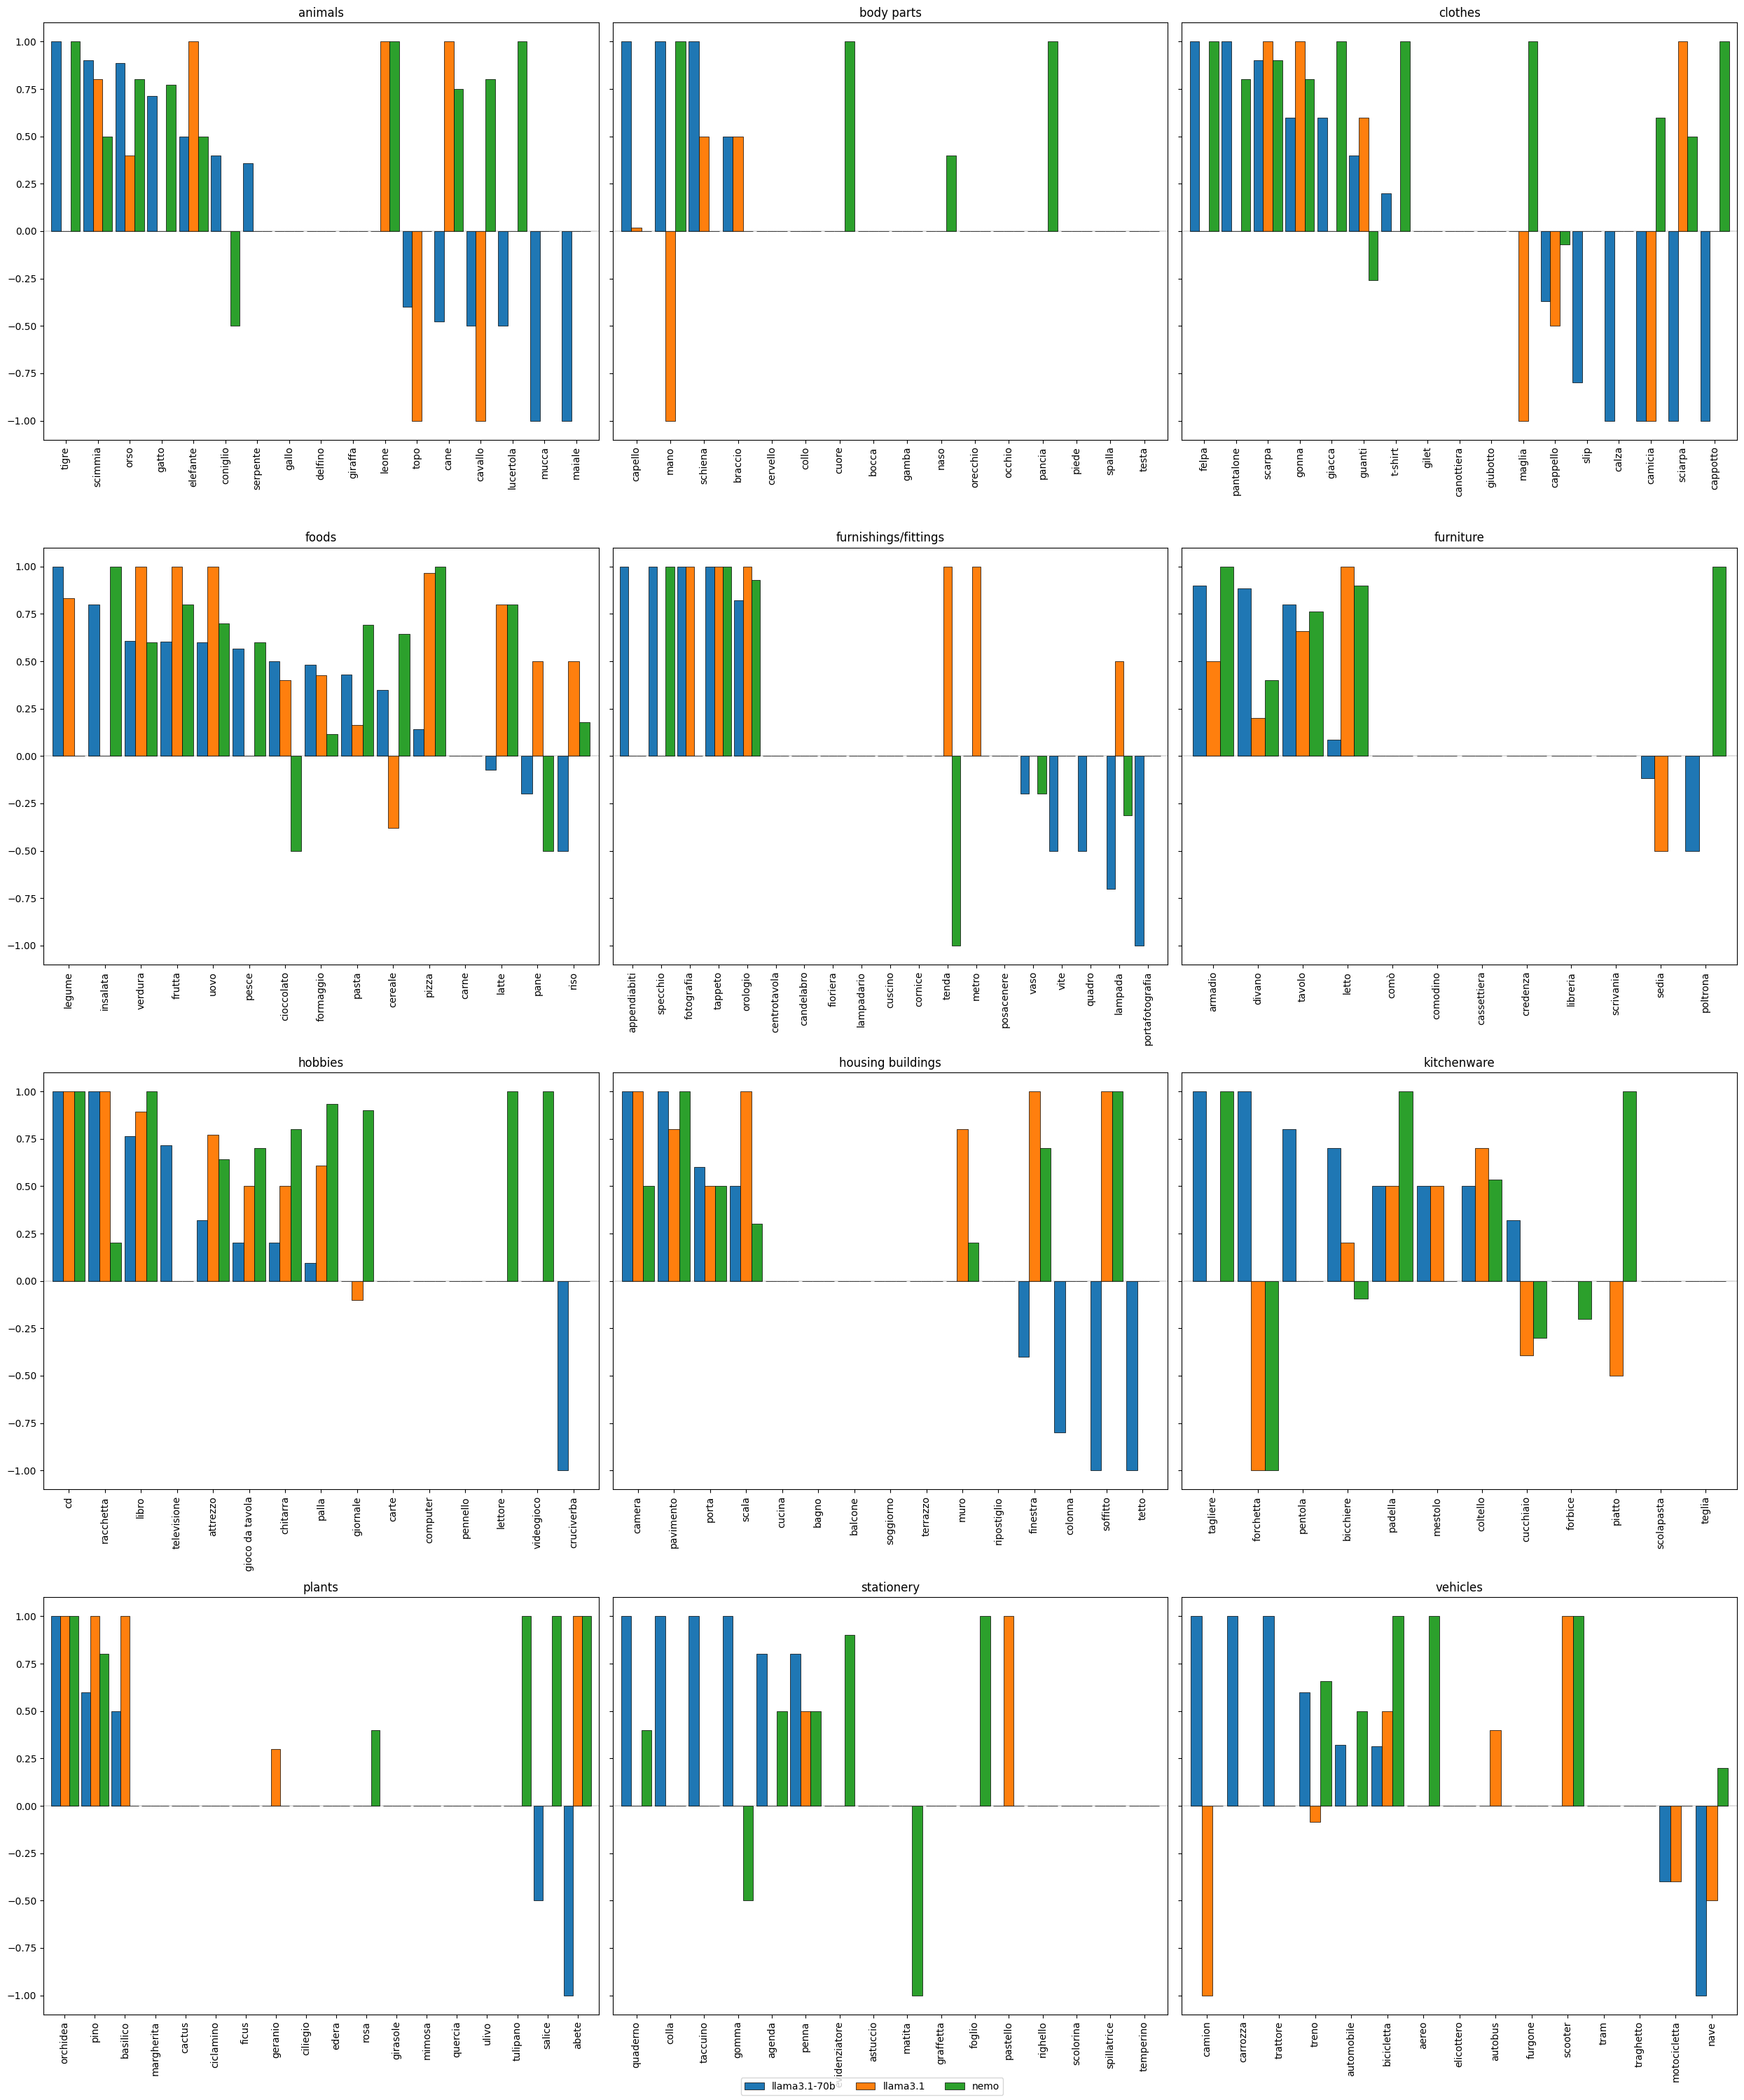

In [119]:
fig, axs = plt.subplots(4, 3, sharey=True, layout="tight")
axs = axs.ravel()

handles = []
labels = []

for i, (k, v) in enumerate(cat_dfs_tonemo.items()):

    v.plot.bar(x="concept", edgecolor="black", width=0.9, linewidth=0.5, ax=axs[i], legend=False, figsize=(25, 30))
    axs[i].set_xlabel(None)
    axs[i].axhline(y=0, color='black', linewidth=0.25, linestyle='--')
    axs[i].set_title(k)
    if i == 0:
        handles, labels = axs[i].get_legend_handles_labels()

fig.legend(handles, labels, loc="lower center", ncol=7)
# fig.subplots_adjust(hspace=0.9, wspace=0.05)
plt.show()

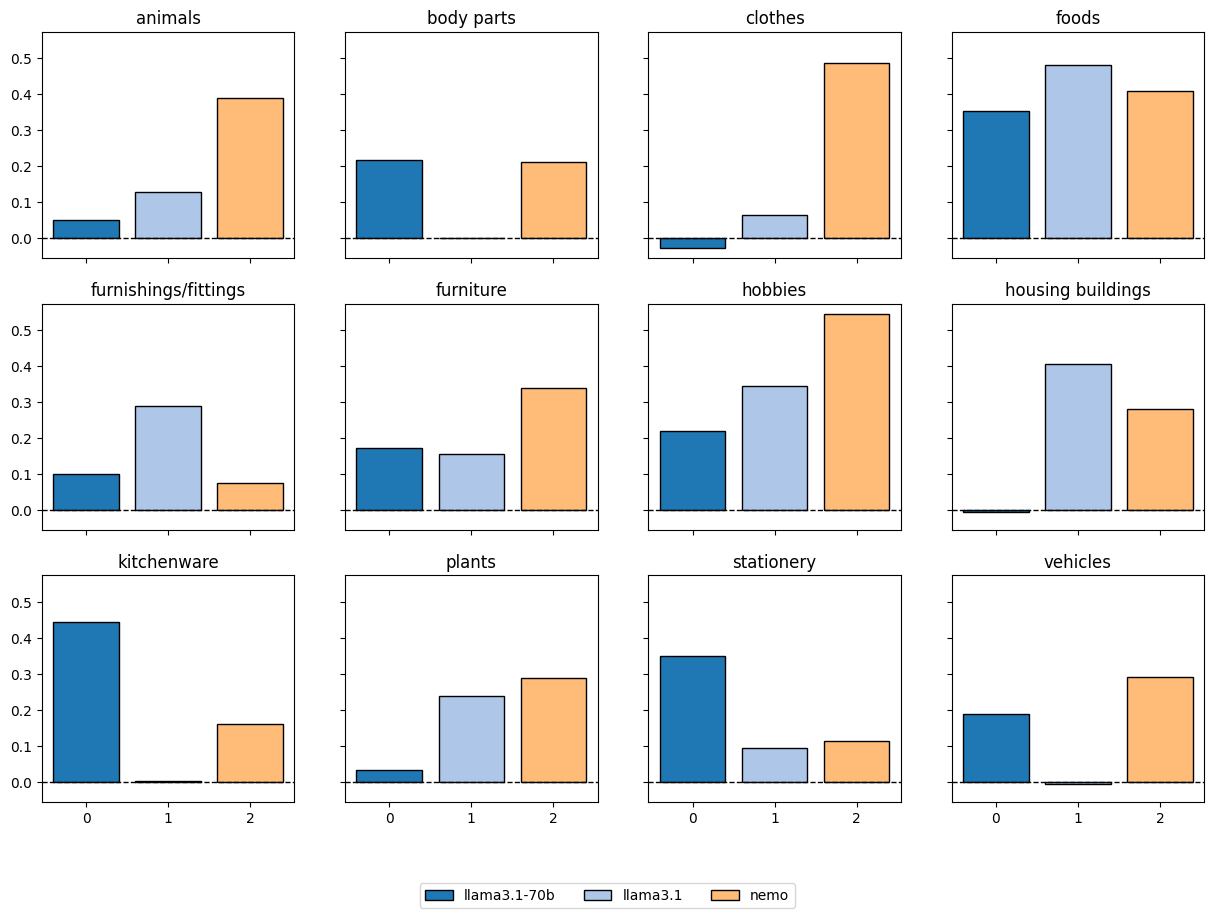

In [121]:
colors = plt.get_cmap('tab20', 12)  # Colormap with 12 unique colors

models = [model for model in cat_dfs_tonemo["animals"].columns.to_list() if model not in ["category", "concept"]]

fig, axs = plt.subplots(3, 4, figsize=(15, 10), sharey=True, sharex=True)
axs = axs.ravel()

handles = []
labels = []

for i, (k, v) in enumerate(cat_dfs_tonemo.items()):
    y = [v[model].mean() for model in models]
    axs[i].bar(x=[i for i in range(len(models))], height=y, edgecolor="black", linewidth=1.0, label=models, color=[colors(i) for i in range(len(models))])
    axs[i].set_title(k)
    axs[i].axhline(y=0, color='black', linewidth=1, linestyle='--')
    
    if i == 0:
        handles, labels = axs[i].get_legend_handles_labels()

fig.legend(handles, labels, loc="lower center", ncol=7)
fig.show()

In [133]:
exemplars_nemo[exemplars_nemo.concept == "autobus"].clean_exemplar.to_list()

['urbano',
 'interurbano',
 'turistico',
 'scolastico',
 'a due piani',
 'a due piani a doppio piano',
 'a due piani a piano singolo',
 'a due piani a piano ribassato',
 'a due piani a piano rialzato',
 'a due piani a piano ribassato e rialzato',
 'a due piani a piano ribassato e rialzato con porta centrale',
 'a due piani a piano ribassato e rialzato senza porta centrale',
 'a due piani a piano ribassato e rialzato con porta centrale e senza porta centrale']

In [135]:
exemplars_llama31_70b[exemplars_llama31_70b.concept == "autobus"].clean_exemplar.to_list()

['a due piani',
 'a tre assi',
 'a pianale ribassato',
 'a pianale rialzato',
 'a propulsione ibrida',
 'a propulsione elettrica',
 'a propulsione diesel',
 'a propulsione a gas',
 'a propulsione a idrogeno',
 'a propulsione ibrido diesel-elettrico',
 'a propulsione ibrido diesel-idrogeno',
 'a propulsione ibrido benzina-elettrico']

In [137]:
data_human[data_human.concept == "AUTOBUS"].sort_values(by="availability", ascending=False).exemplar.to_list()

['AUTOBUS_a due piani',
 'AUTOBUS_di linea',
 'AUTOBUS_scuolabus',
 'AUTOBUS_elettrico',
 'AUTOBUS_pullman',
 'AUTOBUS_snodato',
 'AUTOBUS_filobus',
 'AUTOBUS_minibus',
 'AUTOBUS_a metano',
 'AUTOBUS_corriera',
 'AUTOBUS_privato']